
# Diabetes Prediction — 03 Evaluation

**Goal:** Load the processed dataset and the saved model (from `02_modeling.ipynb`), 
compute evaluation metrics, draw diagnostic plots (Confusion Matrix, ROC, PR), 
estimate feature importance


In [10]:

# =================
# 0) Setup
# =================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.inspection import permutation_importance
import joblib

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

# Paths 
DATA_PROCESSED_PATH = os.path.joinDATA_PROCESSED_PATH = 'C:/Users/nazar/OneDrive/Documentos/machine learning/diabetes_processed.csv'
MODEL_PATH = 'C:/Users/nazar/OneDrive/Documentos/machine learning/diabetes_best_model.joblib'

REPORTS_DIR = os.path.join('C:/Users/nazar/OneDrive/Documentos/machine learning')
FIG_DIR = os.path.join(REPORTS_DIR, 'C:/Users/nazar/OneDrive/Documentos/machine learning')

os.makedirs(FIG_DIR, exist_ok=True)

assert os.path.exists(DATA_PROCESSED_PATH), f"Processed CSV not found at {DATA_PROCESSED_PATH}"


In [12]:

# =================
# 1) Load data & model
# =================
df = pd.read_csv(DATA_PROCESSED_PATH)
target_col = 'Outcome'
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Keep same split as before
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

if os.path.exists(MODEL_PATH):
    model = joblib.load(MODEL_PATH)
    print(f"Loaded model from: {MODEL_PATH}")
else:
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    preprocess = ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='drop')

    model = Pipeline([
        ('prep', preprocess),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    print('No saved model found. Fitting a Logistic Regression baseline...')
    model.fit(X_train, y_train)



Loaded model from: C:/Users/nazar/OneDrive/Documentos/machine learning/diabetes_best_model.joblib



## 2) Metrics & reports


In [13]:

y_pred = model.predict(X_test)

# Probabilities for ROC/PR if available
try:
    y_proba = model.predict_proba(X_test)[:, 1]
except Exception:
    try:
        scores = model.decision_function(X_test)
        from sklearn.preprocessing import MinMaxScaler
        y_proba = MinMaxScaler().fit_transform(scores.reshape(-1,1)).ravel()
    except Exception:
        y_proba = None

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

print(f'Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}  ROC-AUC: {roc:.3f}')
print('\nClassification report:\n', classification_report(y_test, y_pred, digits=3))


Accuracy: 0.721  Precision: 0.641  Recall: 0.463  F1: 0.538  ROC-AUC: 0.801

Classification report:
               precision    recall  f1-score   support

           0      0.748     0.860     0.800       100
           1      0.641     0.463     0.538        54

    accuracy                          0.721       154
   macro avg      0.694     0.661     0.669       154
weighted avg      0.710     0.721     0.708       154




## 3) Plots


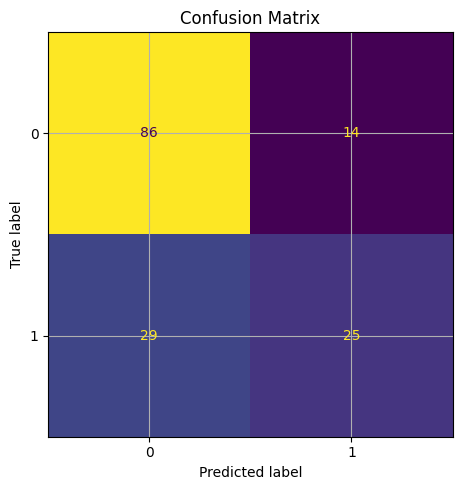

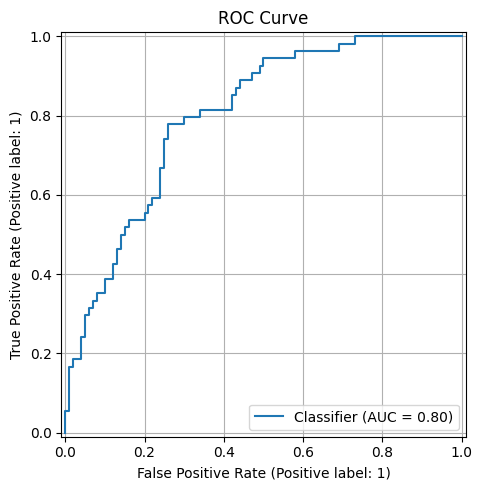

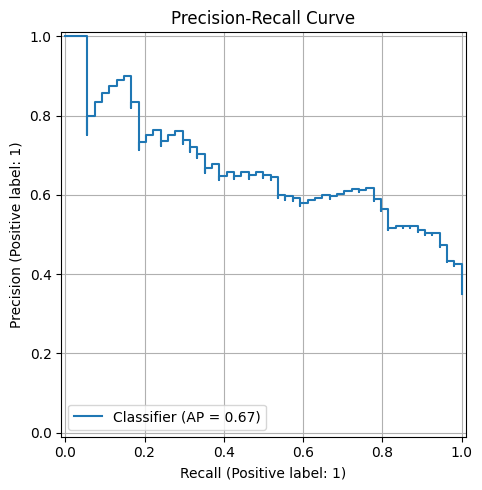

In [14]:

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(ax=ax, cmap=None, colorbar=False)
ax.set_title('Confusion Matrix')
plt.tight_layout()
cm_path = os.path.join(FIG_DIR, 'confusion_matrix.png')
plt.savefig(cm_path, dpi=120)
plt.show()

# ROC Curve
if y_proba is not None:
    fig, ax = plt.subplots()
    RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax)
    ax.set_title('ROC Curve')
    plt.tight_layout()
    roc_path = os.path.join(FIG_DIR, 'roc_curve.png')
    plt.savefig(roc_path, dpi=120)
    plt.show()

# Precision-Recall Curve
if y_proba is not None:
    fig, ax = plt.subplots()
    PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=ax)
    ax.set_title('Precision-Recall Curve')
    plt.tight_layout()
    pr_path = os.path.join(FIG_DIR, 'pr_curve.png')
    plt.savefig(pr_path, dpi=120)
    plt.show()



## 4) Feature importance (Permutation)
Permutation importance is model-agnostic and works directly on the pipeline.


,feature,importance_mean,importance_std
1,Glucose,0.082684,0.024808
7,Age,0.017749,0.010986
5,BMI,0.010823,0.017370
0,Pregnancies,0.009524,0.006213
6,DiabetesPedigreeFunction,0.006061,0.008372
2,BloodPressure,0.000000,0.000000
3,SkinThickness,-0.006061,0.007295
4,Insulin,-0.006061,0.008701


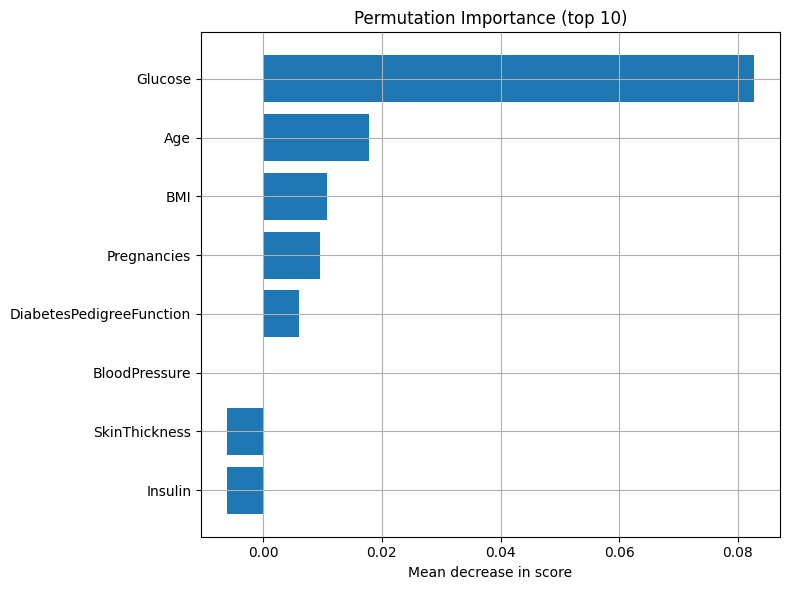

In [15]:

result = permutation_importance(model, X_test, y_test, n_repeats=15, random_state=42, n_jobs=-1)
importances = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values('importance_mean', ascending=False)

display(importances.head(10))

# Plot top 10
top = importances.head(10).iloc[::-1]  # reverse for horizontal bar
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top['feature'], top['importance_mean'])
ax.set_xlabel('Mean decrease in score')
ax.set_title('Permutation Importance (top 10)')
plt.tight_layout()
fi_path = os.path.join(FIG_DIR, 'permutation_importance_top10.png')
plt.savefig(fi_path, dpi=120)
plt.show()



## 5) Save a concise report
This creates `../reports/metrics.md` with the main metrics and paths to figures.


In [17]:
pip install tabulate


^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\nazar\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [18]:

report_path = os.path.join(REPORTS_DIR, 'metrics.md')

lines = []
lines.append('# Evaluation Report — Diabetes Prediction\n')
lines.append('## Summary Metrics\n')
lines.append(f'- Accuracy: **{acc:.3f}**\n')
lines.append(f'- Precision: **{prec:.3f}**\n')
lines.append(f'- Recall: **{rec:.3f}**\n')
lines.append(f'- F1-score: **{f1:.3f}**\n')
if not np.isnan(roc):
    lines.append(f'- ROC-AUC: **{roc:.3f}**\n')
lines.append('\n## Figures\n')
lines.append(f'- Confusion Matrix: `reports/figures/confusion_matrix.png`\n')
if y_proba is not None:
    lines.append(f'- ROC Curve: `reports/figures/roc_curve.png`\n')
    lines.append(f'- Precision-Recall Curve: `reports/figures/pr_curve.png`\n')
lines.append('\n## Top Features (Permutation Importance)\n')
lines.append(importances.head(10).to_markdown(index=False))
lines.append('\n')

with open(report_path, 'w', encoding='utf-8') as f:
    f.write('\n'.join(lines))

print(f'Report written to: {report_path}')
print('Figure files saved under:', FIG_DIR)


Report written to: C:/Users/nazar/OneDrive/Documentos/machine learning\metrics.md
Figure files saved under: C:/Users/nazar/OneDrive/Documentos/machine learning
